# Probabilistic modelling Finnish corona cases

Boilerplate imports and configuration...

In [1]:
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator, DayLocator, MO
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set_context("notebook")
sns.axes_style("darkgrid")

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as tt

from datetime import date

Load a the timeseries data (extracted from HS open data endpoint). Datetime data is aggregated to a daily level where `new cases` are the new cases recorded for that day nationwide, and `cumulative_cases` is the cumulative count up to and including a given date

In [3]:
HS_ENDPOINT = 'https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData'
snapshot_json = requests.get(HS_ENDPOINT).json()
confirmed_records_df = pd.DataFrame.from_records(snapshot_json.get('confirmed'), index='id')

confirmed_records_df['datetime'] = pd.to_datetime(confirmed_records_df.date).dt.tz_localize(None)
confirmed_records_df = confirmed_records_df.drop(columns='date')
confirmed_records_df['date'] = confirmed_records_df.datetime.dt.date
confirmed_records_df = confirmed_records_df.sort_values('date')

confirmed_records_df['new_cases'] = 1
confirmed_records_df['cumulative_cases'] = confirmed_records_df.new_cases.cumsum()

In [4]:
len(snapshot_json.get('recovered'))

10

In [5]:
# datetime_df = pd.read_csv('confirmed_ts.csv', index_col='datetime', parse_dates=['datetime', 'date'])

In [6]:
ts_df = confirmed_records_df.groupby('date').agg({'new_cases': 'sum', 'cumulative_cases': 'max'})
expanded_dates = pd.date_range(ts_df.index.min(), ts_df.index.max())
ts_df = ts_df.reindex(expanded_dates)

ts_df['new_cases'] = ts_df.new_cases.fillna(0)
ts_df['cumulative_cases'] = ts_df.cumulative_cases.fillna(method='backfill').astype(int)

Annotate the data with key events: dummies for each event are used to match days subsequent to a given event

In [7]:
model_start = '2020-02-24'
model_end = '2020-03-30'

events = {
    'Ennen toimenpiteitä': (ts_df.index.min() - pd.Timedelta('1 day')).to_numpy(),
    'THLn ohjeistus': np.datetime64('2020-03-13'),
    'Valmiuslaki': np.datetime64('2020-03-16'),
    'Uusimaa eristetty': np.datetime64('2020-03-28'),
    'end': (ts_df.index.max() + pd.Timedelta('1 day')).to_numpy()
}

event_labels = list(events.keys())[:-1]

In [8]:
ts_df['period'] = pd.cut(ts_df.index, list(events.values()), labels=event_labels)
ts_df['cases_yesterday'] = ts_df.cumulative_cases.shift(1)

In [9]:
regression_df = ts_df.loc[(ts_df.index >= model_start) & (ts_df.index <= model_end), :]
regression_df.loc[:, 'new_cases'] = regression_df.loc[:, 'new_cases'].astype(int)
regression_df.loc[:, 'cases_yesterday'] = regression_df.loc[:, 'cases_yesterday'].astype(int)

event_dummies = pd.get_dummies(regression_df.period)
event_dummies = event_dummies.loc[:, event_dummies.sum() > 0]

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Further feature engineering: try out a few ways to model active contractors from `cases_yesterday`

In [10]:
regression_df.loc[:, 'incubators_gaussian'] = (ts_df.new_cases
                                             .shift(1)
                                             .rolling(window=6, win_type='gaussian')
                                             .sum(std=3).loc[regression_df.index].astype(int))

regression_df.loc[:, 'incubators_static'] = (ts_df.new_cases
                                             .shift(1)
                                             .rolling(window=6)
                                             .sum().loc[regression_df.index].astype(int))

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Support for each time period (i.e., how many days of observations do we have for each event's $R_0$)

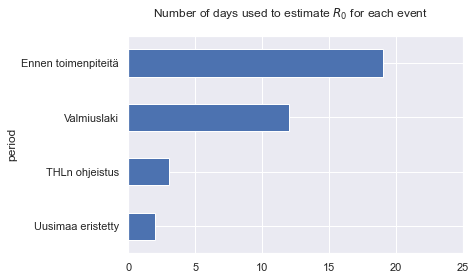

In [11]:
regression_df.groupby('period').new_cases.count().sort_values().plot.barh(xlim=(0, 25))
_ = plt.suptitle('Number of days used to estimate $R_0$ for each event')

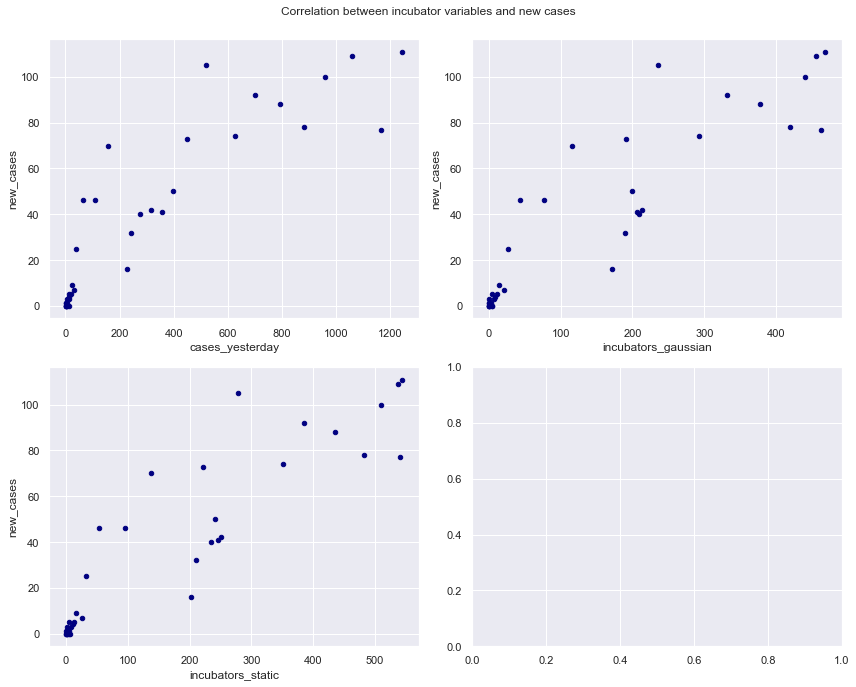

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

_ = regression_df.plot.scatter('cases_yesterday', 'new_cases',
                               ax=axes[0][0], c='navy')

_ = regression_df.plot.scatter('incubators_gaussian', 'new_cases',
                               ax=axes[0][1], c='navy')

_ = regression_df.plot.scatter('incubators_static', 'new_cases',
                               ax=axes[1][0], c='navy')

fig.suptitle('Correlation between incubator variables and new cases', y=.95)

plt.tight_layout(rect=(0, 0, 1, .92))

# Model specification

## Key assuptions
* New cases $\Delta c_t$ for a given date are a result of the number of active incubators for that date $c_{t,a}$, an event dependent $R_{0,e}$ and incubation period $\tau$ (in days)
* Active incubators at time $t$ are assumed to be simply the rolling new infections during the period $[t-\tau, t]$:
$$
    c_{t,a} = c_{t,a}(\tau) = \sum_{p=t-\tau}^{t}c_p
$$
* Assume some externally originated infections $\alpha$ which must have happened to spread the virus into Finland
* Model new cases with a Poisson distribution
* Prior selection
    - $\tau \sim U(2, 14)$ based on prevailing expert opinions
    - $R_{0, e} \sim Gamma(2.5, \sqrt{2})$ with a mean of 2.5 and variance of 2.0, corresponding to a prevailing understanding of 1.5-3.5
    - $\alpha \sim Gamma(0.5, 1)$, i.e., small compared to the internal infection rate

Our likelihood is then
$$
    \Delta c_t = c_{t} - c_{t-1} \sim Poisson(c_{t,a} * \frac{R_{0,e}}{\tau} + \alpha)
$$

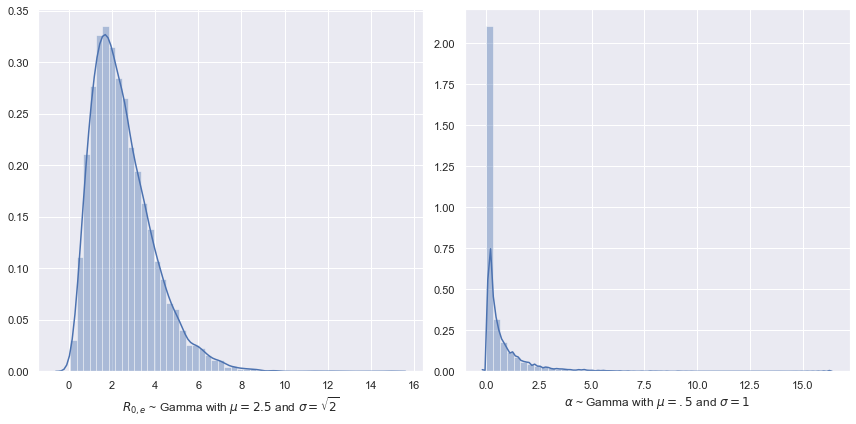

In [13]:
def get_gamma_samples(mu=2.5, sigma=np.sqrt(2), size=10000):
    return np.random.gamma(mu ** 2 / sigma ** 2, sigma ** 2 / mu, size=size)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(get_gamma_samples(), ax=axes[0],
             axlabel='$R_{0,e}$ ~ Gamma with $\mu=2.5$ and $\sigma=\sqrt{2}$')
sns.distplot(get_gamma_samples(mu=.5, sigma=1), ax=axes[1],
             axlabel='$ \\alpha$ ~ Gamma with $\mu=.5$ and $\sigma=1$')

plt.tight_layout()

In [14]:
@as_op(itypes=[tt.lscalar], otypes=[tt.dvector])
def n_incubators_rolling_(incubation_period):
    """A simple rolling total for active incubators 
    """
    window = max(int(incubation_period), 1)
    # window = int(incubation_period)
    return ts_df.new_cases.shift(1).rolling(window=window).sum()[
        regression_df.index].values

@as_op(itypes=[tt.dscalar], otypes=[tt.dvector])
def n_incubators_ewm_(halflife):
    return ts_df.new_cases.shift(1).ewm(halflife=halflife).mean()[
        regression_df.index].values

with pm.Model() as model:
    
    # Roughly as per estimated global range 1.5 - 3.5
    R0 = [pm.Gamma('R0 - {}'.format(e), mu=2.5, sigma=np.sqrt(2))
          for e in event_dummies.columns]

    # 2-14 days
    incubation_period = pm.DiscreteUniform('Incubation period', lower=2, upper=14)
    n_incubators = n_incubators_rolling_(incubation_period)

    # incubation_halflife = pm.Exponential('Incubation halflife', lam=1.0 / 6)
    # incubation_period = 1 / incubation_halflife
    # n_incubators = n_incubators_ewm_(incubation_halflife)
    
    # incubation_period = 6
    # n_incubators = regression_df.cases_yesterday
    # n_incubators = regression_df.incubators_static

    coef_e = pm.math.dot(event_dummies, pm.math.stack(R0)) / incubation_period

    # Infections from non-Finnish exposure
    # alpha = pm.Gamma('alpha', mu=.5, sigma=1, shape=len(event_dummies.columns))
    # coef_a = pm.math.dot(event_dummies, alpha)
    coef_a = pm.Gamma('alpha', mu=.5, sigma=1)
    # coef_a = 0

    likelihood = pm.Poisson('new_cases',
                             mu=coef_e * n_incubators + coef_a,
                             observed=regression_df.new_cases)

    trace = pm.sample(tune=5000, draws=10000)
    ppc = pm.sample_posterior_predictive(trace, samples=10000, model=model)
    
trace_df = pm.trace_to_dataframe(trace)
posterior_df = pd.DataFrame(ppc.get('new_cases')).T
posterior_df.index = regression_df.index

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, R0 - Uusimaa eristetty, R0 - Valmiuslaki, R0 - THLn ohjeistus, R0 - Ennen toimenpiteitä]
>Metropolis: [Incubation period]
Sampling 4 chains, 2 divergences: 100%|██████████| 60000/60000 [02:22<00:00, 419.71draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:16<00:00, 593.96it/s]


## Posterior sampling results

We expect $R_0$ for each event to go down compared to the previous one if they were effective. $\alpha$ should be hopefully small

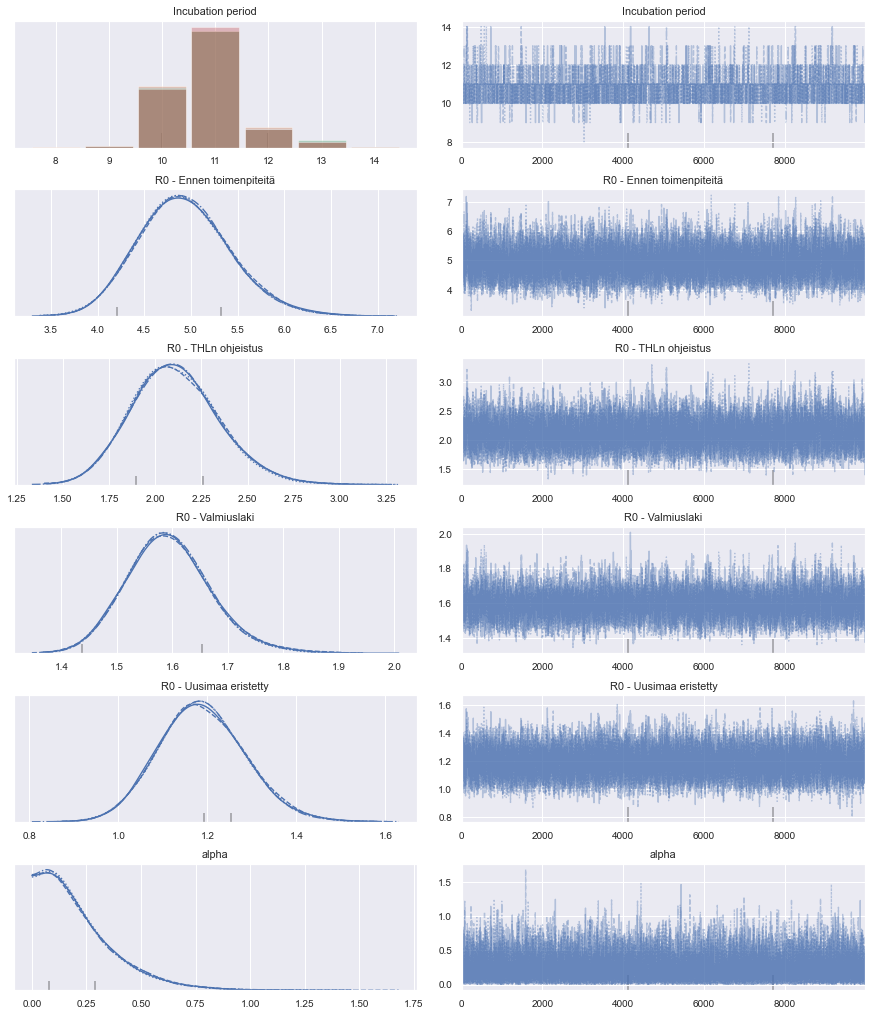

In [15]:
_ = pm.traceplot(trace, figsize=(12, 14))

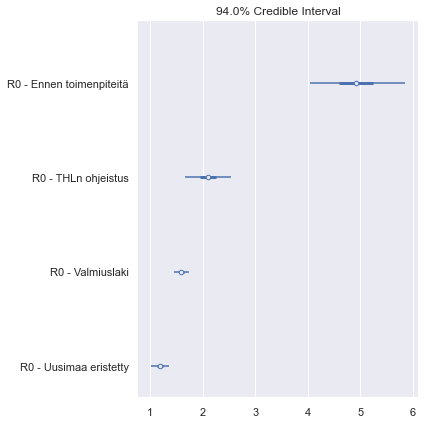

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
pm.forestplot(trace, ax=ax, combined=True, var_names=['R0 - {}'.format(e)
                                                      for e in event_dummies.columns])
plt.tight_layout()

## Posterior predictive checks

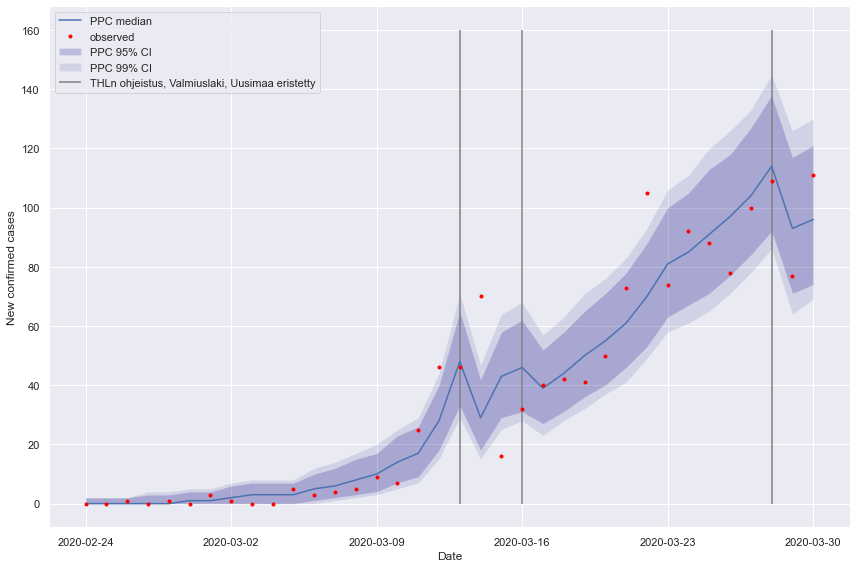

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(posterior_df.index, posterior_df.median(axis=1), label='PPC median')
ax.fill_between(posterior_df.index,
                posterior_df.quantile(q=.025, axis=1),
                posterior_df.quantile(q=.975, axis=1),
                label='PPC 95% CI', alpha=.2, fc='navy')

ax.fill_between(posterior_df.index,
                posterior_df.quantile(q=0.005, axis=1),
                posterior_df.quantile(q=0.995, axis=1),
                label='PPC 99% CI', alpha=.1, fc='navy')


ax.plot(regression_df.index, regression_df.new_cases, '.', c='red', label='observed')

upper_bound = posterior_df.max().max()


events_to_plot = [e for e in event_dummies.columns
                  if events.get(e) > regression_df.index.min()]
dates_to_plot = [events.get(e) for e in events_to_plot]

ax.vlines(x=dates_to_plot, ymin=0, ymax=upper_bound, label=', '.join(events_to_plot),
          colors='gray')

ax.legend(loc='upper left')

ax.xaxis.set_major_locator(WeekdayLocator(MO))
ax.xaxis.set_minor_locator(DayLocator())

ax.set_ylabel('New confirmed cases')
ax.set_xlabel('Date')

plt.tight_layout()

In [18]:
n_obs_in_ci = regression_df.new_cases.between(posterior_df.quantile(q=.025, axis=1),
                                              posterior_df.quantile(q=.975, axis=1)).sum()
share_obs_in_ci =  n_obs_in_ci / len(regression_df)

'{:.1f}%'.format(share_obs_in_ci * 100)

'88.9%'

## Pair-wise comparisons
Did an event have a significant impact on $R_0$?

In [19]:
def compare_events(e0, e1):
    return (trace_df['R0 - {}'.format(e0)] >
            trace_df['R0 - {}'.format(e1)]).sum() / len(trace_df)
event_pairs = [(e0, e1, compare_events(e0, e1))
               for e0 in event_dummies
               for e1 in event_dummies
               if e0 is not e1]

In [20]:
(pd.DataFrame.from_records(event_pairs,
                           columns=['e0', 'e1', '$\mathbf{P}(R_{0, e0} > R_{0, e1}$)'],
                           index=['e0', 'e1'])
     .unstack(level=1, fill_value=0)
     .reindex(event_dummies.columns, axis=1, level=1)
     .reindex(event_dummies.columns.rename('e0')))

$\mathbf{P}(R_{0, e0} > R_{0, e1}$)                 \
e1                                  Ennen toimenpiteitä THLn ohjeistus   
e0                                                                       
Ennen toimenpiteitä                                 0.0        1.00000   
THLn ohjeistus                                      0.0        0.00000   
Valmiuslaki                                         0.0        0.00425   
Uusimaa eristetty                                   0.0        0.00000   

                                                   
e1                  Valmiuslaki Uusimaa eristetty  
e0                                                 
Ennen toimenpiteitä    1.000000          1.000000  
THLn ohjeistus         0.995750          1.000000  
Valmiuslaki            0.000000          0.999925  
Uusimaa eristetty      0.000075          0.000000

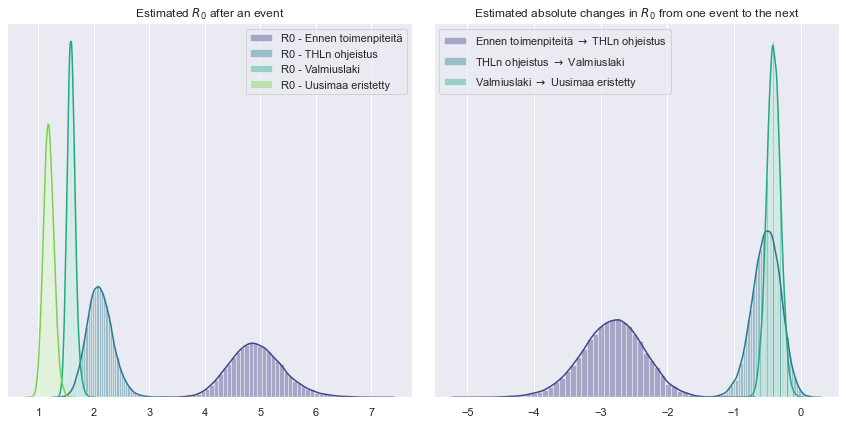

In [27]:
def event_delta_trace(e0, e1):
    return (trace_df['R0 - {}'.format(e1)] - trace_df['R0 - {}'.format(e0)])

es = list(event_dummies.columns)

event_delta_traces = {
    '{} $\\rightarrow$ {}'.format(es[i], es[i+1]): event_delta_trace(es[i], es[i+1])
    for i in range(len(es) - 1)}

n_traces = len(event_delta_traces)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


sns.set_palette("viridis", len(es))


for e in ['R0 - {}'.format(e) for e in es]:
    sns.distplot(trace_df[e], ax=ax1, label=e)


for i in range(n_traces):
    name = list(event_delta_traces.keys())[i]
    event_trace = list(event_delta_traces.values())[i]
    sns.distplot(event_trace, ax=ax2, label=name)

ax1.set_xlabel(None)
ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
    
ax1.legend()
ax2.legend()
ax1.set_title('Estimated $R_0$ after an event')

ax2.set_title('Estimated absolute changes in $R_0$ from one event to the next')
plt.tight_layout()